In [1]:
### Defining Environment variables pointing to user folders
from os import environ,path

environ.setdefault('HOME_DIR', "/workarea/local/shared/"+ environ['USERNAME'])
environ.setdefault('TRAINING_DATA_FOLDER',"/j100")
environ.setdefault('MODEL_STORAGE',environ['HOME_DIR']+"/trained_models"+environ['TRAINING_DATA_FOLDER'])

feather_folder = environ['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+environ['TRAINING_DATA_FOLDER']
environ.setdefault("TRAIN_DATA"     , feather_folder+"/acceptance-train")
environ.setdefault("VALIDATION_DATA", feather_folder+"/acceptance-validation")

environ.setdefault("MODEL_VARIANT","v1")
default_output_model = "/models/acceptance/saved_model.pb"
if environ['MODEL_VARIANT'] != '':
    model_path,model_name = path.split(default_output_model)
    default_output_model = path.join(model_path,environ['MODEL_VARIANT'], model_name)
environ.setdefault('OUTPUT_MODEL',environ['MODEL_STORAGE']+default_output_model)

_ = environ.setdefault('NB_EXPORT',"True") # whether export notebooks

# Training of the *Acceptance model*
##### Tested on environment `TensorFlow on GPU` from [landerlini/lhcbaf:v0p8](https://hub.docker.com/r/landerlini/lhcbaf)

In this notebook we setup the training for the acceptance model, based on a Deep Neural Network.

This notebook is part of a pipeline and requires the data preprocessed with the notebook [Preprocessing.ipynb](./Preprocessing.ipynb).

## Enviornment setup and libraries

In this notebooks we will use the standard software stack for TensorFlow machine learning applications.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

To ensure a GPU is found and properly loaded in the notebook kernel to the benefit of TensorFlow, the output of the following block should be similar to `'/device:GPU:0'`.
If a GPU is not found, the string will be empty.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Load datasets

Preprocessed datasets were stored in *Apache feather* format and can be reloaded with our custom `FeatherReader` designed to stream the datasets into TensorFlow or Dask format.

We are loading in particular:
 * the **training** dataset to train the network
 * the **validation** dataset to evaluate the network performance at each epoch and identify overtraining effects

In [4]:
from feather_io import FeatherReader    

train_dataset = FeatherReader(environ.get("TRAIN_DATA", "acceptance-train")).as_tf_dataset()
validation_dataset = FeatherReader(environ.get("VALIDATION_DATA", "acceptance-validation")).as_tf_dataset()

We load a small batch of data to identify the number of conditional and target features and automate the definition of the neural network architecture.

In [5]:
X, y = next(iter(train_dataset.batch(1_000_000)))
X.shape

TensorShape([1000000, 12])

## Model definition

The function we are modelling is not a trivial one, requiring a sufficiently deep neural network.
In order to limit the effect of the vanishing gradient and make the trainig procedure faster, we are using the concept of Residual Layer, introducing skipping connections between the input and the output of each layer.

With residual layers, the neural network is trained to learn the deviation from identity which is a much less demanding task than learning the whole transformation.

The output layer of the neural network has a sigmoid activation function to be mapped into the interval 0-1 and being interpreted as the **probability for the particle of being in acceptance**.



In [6]:
input = tf.keras.layers.Input(batch_input_shape=[None]+X.shape[1:])
x = tf.keras.layers.Dense(
    128, activation='tanh',
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.L2(1e-3)
)(input)

for i in range(10):
    r = tf.keras.layers.Dense(128, activation='tanh', kernel_initializer='zeros')(x)
    x = tf.keras.layers.Add()([x, r])
x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

model = tf.keras.Model(inputs=[input], outputs=[x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1664        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
add (Add)                       (None, 128)          0           dense[0][0]                      
                                                                 dense_1[0][0]                

The rest of the training procedure is rather standard:
 * loss function: [binary cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
 * optimizer: [RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop) or [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [7]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop

To speed up convergence, we split the training procedure in two steps. 
First, we proceed at high learning rate and then we operate some fine tuning of the network drastrically reducing it.
Similar results might be obtained in a more elegant way using a keras [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/).

Instead of setting a fixed number of epochs, we switch from one learning rate to the next one upon lack of improvement for at least 5 epochs.

In [9]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.01), optimizer=RMSprop(10e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

batch_size=100_000

training_data = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
validation_data=next(iter(validation_dataset.batch(batch_size)))

history = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 9s 279ms/step - loss: 1.2140 - val_loss: 0.7943
Epoch 2/50
26/26 [==============================] - 8s 275ms/step - loss: 0.6767 - val_loss: 0.6677
Epoch 3/50
26/26 [==============================] - 8s 272ms/step - loss: 0.5646 - val_loss: 0.4584
Epoch 4/50
26/26 [==============================] - 8s 274ms/step - loss: 0.4527 - val_loss: 0.4712
Epoch 5/50
26/26 [==============================] - 8s 272ms/step - loss: 0.4079 - val_loss: 0.4802
Epoch 6/50
26/26 [==============================] - 8s 276ms/step - loss: 0.3817 - val_loss: 0.3770
Epoch 7/50
26/26 [==============================] - 8s 272ms/step - loss: 0.3930 - val_loss: 0.3667
Epoch 8/50
26/26 [==============================] - 8s 270ms/step - loss: 0.3649 - val_loss: 0.3712
Epoch 9/50
26/26 [==============================] - 8s 270ms/step - loss: 0.3427 - val_loss: 0.3537
Epoch 10/50
26/26 [==============================] - 8s 275ms/step - loss: 0.3392 - val_loss: 0.3126

In [10]:
model.compile(loss=BinaryCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_ft = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 8s 264ms/step - loss: 0.2451 - val_loss: 0.2389
Epoch 2/50
26/26 [==============================] - 7s 263ms/step - loss: 0.2372 - val_loss: 0.2348
Epoch 3/50
26/26 [==============================] - 7s 256ms/step - loss: 0.2327 - val_loss: 0.2305
Epoch 4/50
26/26 [==============================] - 8s 266ms/step - loss: 0.2285 - val_loss: 0.2268
Epoch 5/50
26/26 [==============================] - 7s 262ms/step - loss: 0.2255 - val_loss: 0.2244
Epoch 6/50
26/26 [==============================] - 7s 263ms/step - loss: 0.2226 - val_loss: 0.2215
Epoch 7/50
26/26 [==============================] - 8s 273ms/step - loss: 0.2196 - val_loss: 0.2175
Epoch 8/50
26/26 [==============================] - 8s 267ms/step - loss: 0.2174 - val_loss: 0.2154
Epoch 9/50
26/26 [==============================] - 8s 272ms/step - loss: 0.2148 - val_loss: 0.2127
Epoch 10/50
26/26 [==============================] - 8s 266ms/step - loss: 0.2130 - val_loss: 0.2112

The two regimes are well visibile in the plot below, combining the two training phases in a single epoch count.

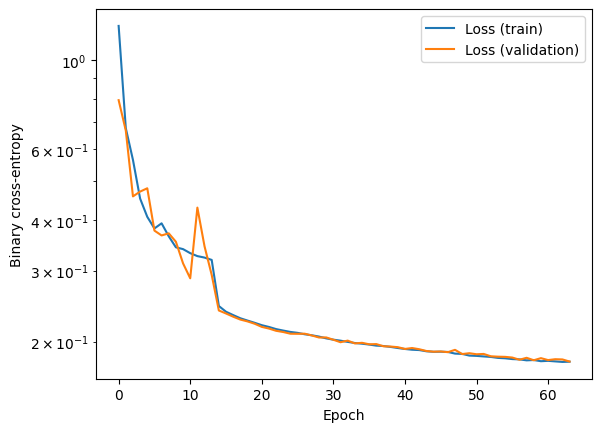

In [11]:
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Loss (train)")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.yscale('log')
plt.legend()
plt.show()

## A first, rough validation

While a proper validation of the model is demanded to a dedicated notebook, here we check that the training was not completely failed and provides reasonable numbers.

In particular, we compare the distributions of the training lables and of the predictions.

Clearly, the training labels are either 1 or 0 because a particle is either in acceptance or not. Instead, the output of the neural network is a probability and hence it will be distributed between 0 and 1. 

The comparison is used to ensure that both the training labels and the network output are not unreasonable, for example collapsed into a single value or with training labels belonging to a single category.

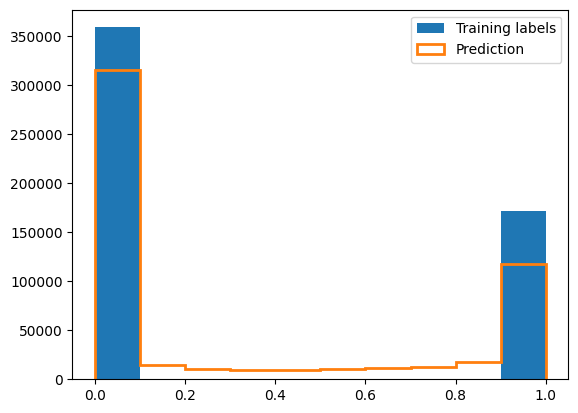

In [12]:
Xv, yv = next(iter(validation_dataset.batch(1_000_000).as_numpy_iterator()))
yv_hat = model.predict(Xv, batch_size=len(Xv))
bins = np.linspace(0, 1, 11)
plt.hist(yv, bins=bins, label="Training labels")
plt.hist(yv_hat, bins=bins, histtype='step', linewidth=2, label="Prediction")
plt.legend()
plt.show()

Then we can compare the distribution of a preprocessed variable before and after the application of the acceptance requirement.

Here, for example, we consider the preprocessed log-value of the momentum.

Since the variable is preprocessed, without applying any cut (**Generated**) we have a perfectly normalized Gaussian.

Applying the criterion `acceptance == 1` we get another distribution that we expect to model with decent approximation by applying the response of the trained neural networks as weights to the **Generated** dataset.

The comparison of the two histograms (obtained by applying a cut on the true acceptance or applying a weight on the acceptance probability) provides a first validation on the quality of the parametrization.

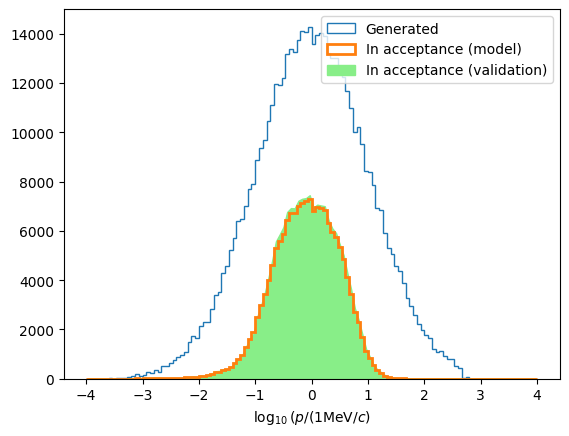

In [13]:
log_p = Xv[:,3]
bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p, bins=bins, weights=yv.flatten())
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=yv_hat.flatten())

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="Generated", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="In acceptance (model)", histtype='step', linewidth=2)
#plt.plot((bins[1:] + bins[:-1])/2, predicted_numerator, label="In acceptance (model)")
plt.fill_between(
    (bins[1:] + bins[:-1])/2, np.zeros(len(true_numerator)), true_numerator,
    label="In acceptance (validation)",
    color='#88ee88'
)
plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend()
plt.show()

## Export the model
Finally, we export the model to the same folder where the pretraining step was stored.

In [67]:
from json import dump
import os 

def Stringfy(element):
    "recursively convert into string all dictionary values"
    for k,val in element.items():
        if isinstance(val,dict):
            element[k] = Stringfy(val)
        else:
            element[k] = str(val)
    return element
        

def WriteModelProperties(path,model=None,history=None):
    """write the property of the model (and history) in the path"""
    
    assert (model is not None or history is not None), "either model or history must be given"
        
    # create output folder if not existing
    output_path = os.path.dirname(path)
    if not os.path.exists(output_path) and output_path != '':
        os.mkdir(output_path)
    
    info2save = dict(model={})
    
    if history is not None:
        model                = history.model
        info2save['history'] = history.history
    
    info2save['model']['layers'] = []
    for L in model.layers:
        info2save['model']['layers'].append(L.get_config())
        info2save['model']['layers'][-1].update(
            {
                'module': L.__module__,
                'class_name': L.__class__.__name__
            })
    
    info2save['model']['optimizer'] = Stringfy(model.optimizer.get_config())
    
    with open(path, "w") as outfile:
        dump(info2save, outfile)
    print("Information written to: "+path)
    #return info2save
        

In [22]:
import os
base_dir,output_model = os.path.split(environ['OUTPUT_MODEL'])
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
model.save(base_dir)



INFO:tensorflow:Assets written to: /workarea/local/shared/scapelli/trained_models/j100/models/acceptance/v1/assets


/usr/local/miniconda3/envs/tf_on_gpu/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
# save model and training information
base_dir = path.dirname(environ['OUTPUT_MODEL'])
info_path = path.join(base_dir, "model_info.json")
WriteModelProperties(info_path,model,history=history_ft)

NameError: name 'history_ft' is not defined

In [68]:
WriteModelProperties(info_path,model)

Information written to: /workarea/local/shared/scapelli/trained_models/j100/models/acceptance/v1/model_info.json


{'model': {'layers': [{'batch_input_shape': (None, 12),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1',
    'module': 'keras.engine.input_layer',
    'class_name': 'InputLayer'},
   {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'units': 128,
    'activation': 'tanh',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L2',
     'config': {'l2': 0.0010000000474974513}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None,
    'module': 'keras.layers.core',
    'class_name': 'Dense'},
   {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 128,
    'activation': 'tanh',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_initializer

## Conclusion

In this notebook we have:
 * loaded the training and validation data
 * defined a neural network model for the acceptance
 * trained the model on simulated data
 * performed a couple of sanity checks to ensure the training procedure did not fail
 * exported the model to disk
 
In the next notebook we will perform a more detaile validation, by splitting the sample in kinematic bins and comparing for each bin the distribution of particles in acceptance.

In [27]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    import os
    nb_save  = "/workarea/local/shared/scapelli/notebooks_exports"         # export output dir
    nb_save  = nb_save+environ['TRAINING_DATA_FOLDER']                     # according to train data
    if environ['MODEL_VARIANT'] != '':
        nb_save  = nb_save+'/'+environ['MODEL_VARIANT']                    # according to model variant
    if not os.path.isdir(nb_save): os.makedirs(nb_save)                    # create if not exists
    nbs_path = "/workarea/local/shared/scapelli/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Acceptance.ipynb"                                       # notebook name
    extensions  = ["html","pdf"]                                           # export formats
    for ext in extensions:
        os.system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))

Exported Acceptance.ipynb as html,pdf in /workarea/local/shared/scapelli/notebooks_exports/j100/v1
